# Hypothesis testing for brushing experiments: Overview

## Imports

In [1]:
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder
from theano import tensor as tt
from sys import exit
import pickle
import arviz 

In [2]:
inpath = '../Output/SingleParameters/'
outpath = '../Output/Overview/'

## Prepare some variables for later use

In [3]:
df = pd.read_excel("../Data/brushing_v2.xlsx").dropna("columns")

In [4]:
factorNames = ['Material','Brush', 'Dirt', 'Before.after','Area'] 

In [5]:
x1contrast_dict = {'No_Brush_Is_Dirt_vs_No_Brush_No_Dirt': [0, 0,1,-1],
                  'Is_Brush_No_Dirt_vs_No_Brush_No_Dirt': [0, 1,0,-1],
                  'Is_Brush_Is_Dirt_vs_No_Brush_No_Dirt': [1, 0,0,-1]} 
x2contrast_dict = {} 
x1x2contrast_dict = {}

In [6]:
quantityNames = ['epLsar', 'Asfc', 'Smfc', 'HAsfc9',
       'HAsfc81', 'Sq.SL', 'Ssk.SL', 'Sku.SL', 'Sp.SL', 'Sv.SL', 'Sz.SL',
       'Sa.SL', 'Smr.SL', 'Smc.SL', 'Sxp.SL', 'Sal.SL', 'Str.SL', 'Std.SL',
       'Sdq.SL', 'Sdr.SL', 'Vm.SL', 'Vv.SL', 'Vmp.SL', 'Vmc.SL', 'Vvc.SL',
       'Vvv.SL', 'Maximum.depth.of.furrows.SL', 'Mean.depth.of.furrows.SL',
       'Mean.density.of.furrows.SL', 'Isotropy.SL', 'First.Direction.SL',
       'Second.Direction.SL', 'Third.Direction.SL', 'Isotropy.SL.1', 'Sq.SF',
       'Ssk.SF', 'Sku.SF', 'Sp.SF', 'Sv.SF', 'Sz.SF', 'Sa.SF', 'Smr.SF',
       'Smc.SF', 'Sxp.SF', 'Sal.SF', 'Str.SF', 'Std.SF', 'Sdq.SF', 'Sdr.SF',
       'Vm.SF', 'Vv.SF', 'Vmp.SF', 'Vmc.SF', 'Vvc.SF', 'Vvv.SF',
       'Maximum.depth.of.furrows.SF', 'Mean.depth.of.furrows.SF',
       'Mean.density.of.furrows.SF', 'Isotropy.SF', 'First.Direction.SF',
       'Second.Direction.SF', 'Third.Direction.SF', 'Isotropy.SF.1']

In [7]:
idDatasetsDict = dict(enumerate(quantityNames))

In [8]:
dictQuantitiy = {}
dictHPD1 = {}
dictSig1 = {}
dictHPD2 = {}
dictSig2 = {}
dictHPD3 = {}
dictSig3 = {}

## Load results to get overview over all significance tests

In [9]:
for index,idMeasure in idDatasetsDict.items():   
    
            identifier = idMeasure
            try:                
                with open(inpath + 'model_{}.pkl'.format(identifier), 'rb') as buff:
                    data = pickle.load(buff) 
                    
                
                filtered = df[factorNames +  [idMeasure]]
                
                filtered = pd.get_dummies(filtered, columns=['Before.after'])
                
                filtered['Weighted_'+idMeasure] = filtered[idMeasure]*filtered['Before.after_After']-filtered[idMeasure]*filtered['Before.after_Before']
                
                filtered = filtered.groupby(['Material','Brush','Dirt','Area']).sum().reset_index()[['Material','Brush','Dirt','Area','Weighted_'+idMeasure]]
                
                filtered = filtered.replace({'Yes': 'Is'})
                
                filtered = filtered.rename(columns={'Weighted_'+idMeasure : 'Delta_' +idMeasure})
                              
                melt = pd.DataFrame()
                melt["Factor1"] = filtered['Brush']+"_Brush_" + filtered['Dirt'] + "_Dirt"
                melt["Factor2"] = filtered["Material"]
                melt['Value'] = filtered['Delta_'+idMeasure]
                mu_Val = melt['Value'].mean()
                sig_Val = melt['Value'].std(ddof=1)
                melt['z'] = (melt['Value'] - mu_Val)/sig_Val

                basic_model, trace = data['model'], data['trace']
                
                b1_sample = sig_Val*trace['b1']+mu_Val
                b2_sample = sig_Val*trace['b2']+mu_Val
                b1b2_sample = sig_Val*trace['M']+mu_Val
                                
                dictQuantitiy[index] = idMeasure                
                
                for indexContrast, (key, value) in enumerate(x1contrast_dict.items()):
                        contrast = np.dot(b1_sample, value)
                        
                        hpd = arviz.hpd(contrast)                    
                        significance = 0.0 <= hpd[0] or 0.0 >= hpd[-1]  
                        
                        if indexContrast == 0: 
                            dictHPD1[index] = hpd
                            dictSig1[index] = significance
                        if indexContrast == 1: 
                            dictHPD2[index] = hpd
                            dictSig2[index] = significance
                            
                        if indexContrast == 2: 
                            dictHPD3[index] = hpd
                            dictSig3[index] = significance
                        
            except:
                print("Error for {}".format(idMeasure))
                pass
                    

In [10]:
dictConverted = {'measuredQuantity':list(dictQuantitiy.values()),
                 'hpd1':list(dictHPD1.values()),
                 'No_Brush_Is_Dirt_Significant':list(dictSig1.values()),
                 'hpd2':list(dictHPD2.values()),
                 'Is_Brush_No_Dirt_Significant':list(dictSig2.values()),
                 'hpd3':list(dictHPD3.values()),
                 'Is_Brush_Is_Dirt_Significant':list(dictSig3.values())
                }

In [11]:
dfSig = pd.DataFrame.from_dict(dictConverted)
dfSig['lowHPD1'] = dfSig.apply(lambda r: r['hpd1'][0],axis=1)
dfSig['highHPD1'] = dfSig.apply(lambda r: r['hpd1'][-1],axis=1)
dfSig = dfSig.drop('hpd1', 1)
dfSig['lowHPD2'] = dfSig.apply(lambda r: r['hpd2'][0],axis=1)
dfSig['highHPD2'] = dfSig.apply(lambda r: r['hpd2'][-1],axis=1)
dfSig = dfSig.drop('hpd2', 1)
dfSig['lowHPD3'] = dfSig.apply(lambda r: r['hpd3'][0],axis=1)
dfSig['highHPD3'] = dfSig.apply(lambda r: r['hpd3'][-1],axis=1)
dfSig = dfSig.drop('hpd3', 1)
dfSig['anySig'] = dfSig.apply(lambda r: r['No_Brush_Is_Dirt_Significant'] or r['Is_Brush_No_Dirt_Significant'] or r['Is_Brush_Is_Dirt_Significant'],axis=1)
dfSig

measuredQuantity  No_Brush_Is_Dirt_Significant  \
0                epLsar                         False   
1                  Asfc                         False   
2                  Smfc                         False   
3                HAsfc9                         False   
4               HAsfc81                         False   
..                  ...                           ...   
58          Isotropy.SF                         False   
59   First.Direction.SF                         False   
60  Second.Direction.SF                         False   
61   Third.Direction.SF                         False   
62        Isotropy.SF.1                         False   

    Is_Brush_No_Dirt_Significant  Is_Brush_Is_Dirt_Significant    lowHPD1  \
0                           True                          True  -0.000479   
1                          False                         False  -3.144006   
2                          False                         False  -7.991613   
3                           True                         False  -0.035967   
4                          False                         False  -0.040201   
..                           ...                           ...        ...   
58                          True                         False -33.362462   
59                         False                         False -43.939526   
60                         False                         False  -3.042626   
61                         False                         False  -4.098905   
62                          True                         False -23.941132   

      highHPD1    lowHPD2    highHPD2    lowHPD3    highHPD3  anySig  
0     0.000016  -0.000677   -0.000107  -0.000690   -0.000130    True  
1    12.387835  -3.370301   11.936648  -5.530938    8.454338   False  
2   121.428134  -5.720968  134.487161  -8.276030  126.684908   False  
3     0.465312   0.056452    0.665604  -0.021494    0.487958    True  
4     0.605657  -0.003064    0.719795  -0.007711    0.650600   False  
..         ...        ...         ...        ...         ...     ...  
58    2.723042  22.193711   58.361448 -11.786072   24.525002    True  
59   27.590497 -16.610605   57.262991 -25.454533   42.683465   False  
60  107.092195 -68.126598   30.536122 -27.395579   72.869765   False  
61  141.343732 -53.587714   66.320503 -17.192689  110.670642   False  
62   13.655180   4.088759   46.506207  -1.825278   37.043055    True  

[63 rows x 11 columns]

### All rows with at least one significant result

In [12]:
dfSig[dfSig.anySig]

measuredQuantity  No_Brush_Is_Dirt_Significant  \
0            epLsar                         False   
3            HAsfc9                         False   
7            Sku.SL                         False   
12           Smr.SL                          True   
43           Sxp.SF                         False   
45           Str.SF                         False   
54           Vvv.SF                          True   
58      Isotropy.SF                         False   
62    Isotropy.SF.1                         False   

    Is_Brush_No_Dirt_Significant  Is_Brush_Is_Dirt_Significant      lowHPD1  \
0                           True                          True    -0.000479   
3                           True                         False    -0.035967   
7                           True                         False    -0.956137   
12                         False                         False     0.009736   
43                          True                         False -1140.309510   
45                          True                         False    -0.324711   
54                          True                         False    -0.099113   
58                          True                         False   -33.362462   
62                          True                         False   -23.941132   

     highHPD1      lowHPD2   highHPD2     lowHPD3    highHPD3  anySig  
0    0.000016    -0.000677  -0.000107   -0.000690   -0.000130    True  
3    0.465312     0.056452   0.665604   -0.021494    0.487958    True  
7    0.715376     0.293037   2.012304   -1.588012    0.049136    True  
12   0.331283    -0.159055   0.127101   -0.195928    0.090206    True  
43  59.367195 -1480.342773 -79.200178 -846.684902  332.446258    True  
45   0.023357     0.236730   0.603433   -0.105132    0.248463    True  
54  -0.019024    -0.121133  -0.035998   -0.070542    0.005308    True  
58   2.723042    22.193711  58.361448  -11.786072   24.525002    True  
62  13.655180     4.088759  46.506207   -1.825278   37.043055    True

In [13]:
dfSig[dfSig.anySig].to_csv(outpath+'tableSignificants.csv')

Count the number of significant results

In [14]:
dfSig[dfSig.anySig].index.size

9

Get fraction of significant results

In [15]:
1.0*dfSig[dfSig.anySig].index.size / len(quantityNames)

0.14285714285714285

## Get significance plots

In [16]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
sns.set_style("ticks")

In [17]:
def plotEmpty(ax):
    ax.plot()
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


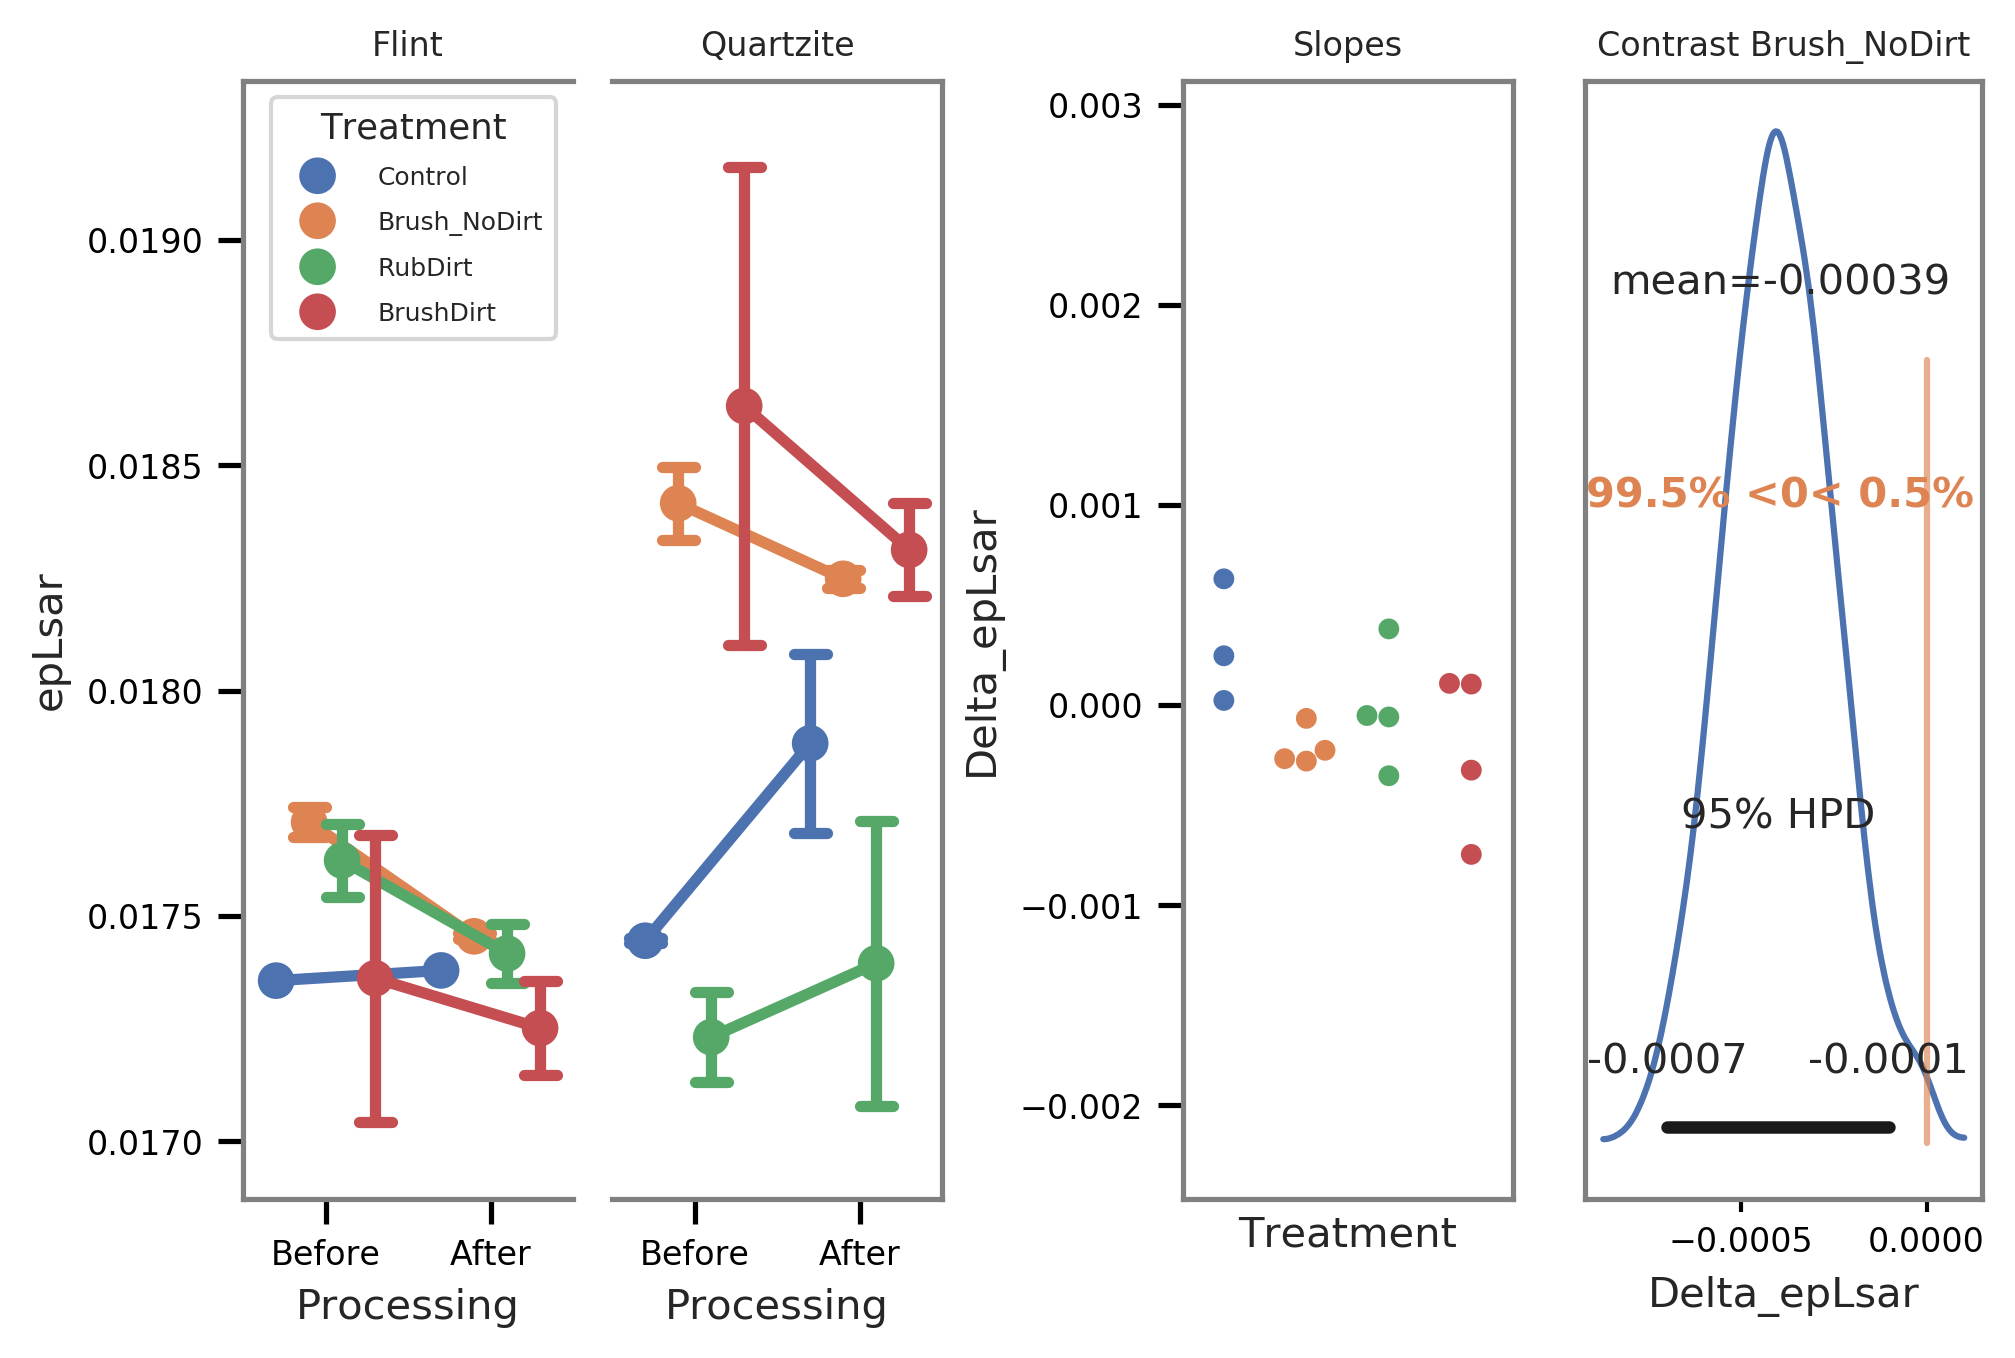

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


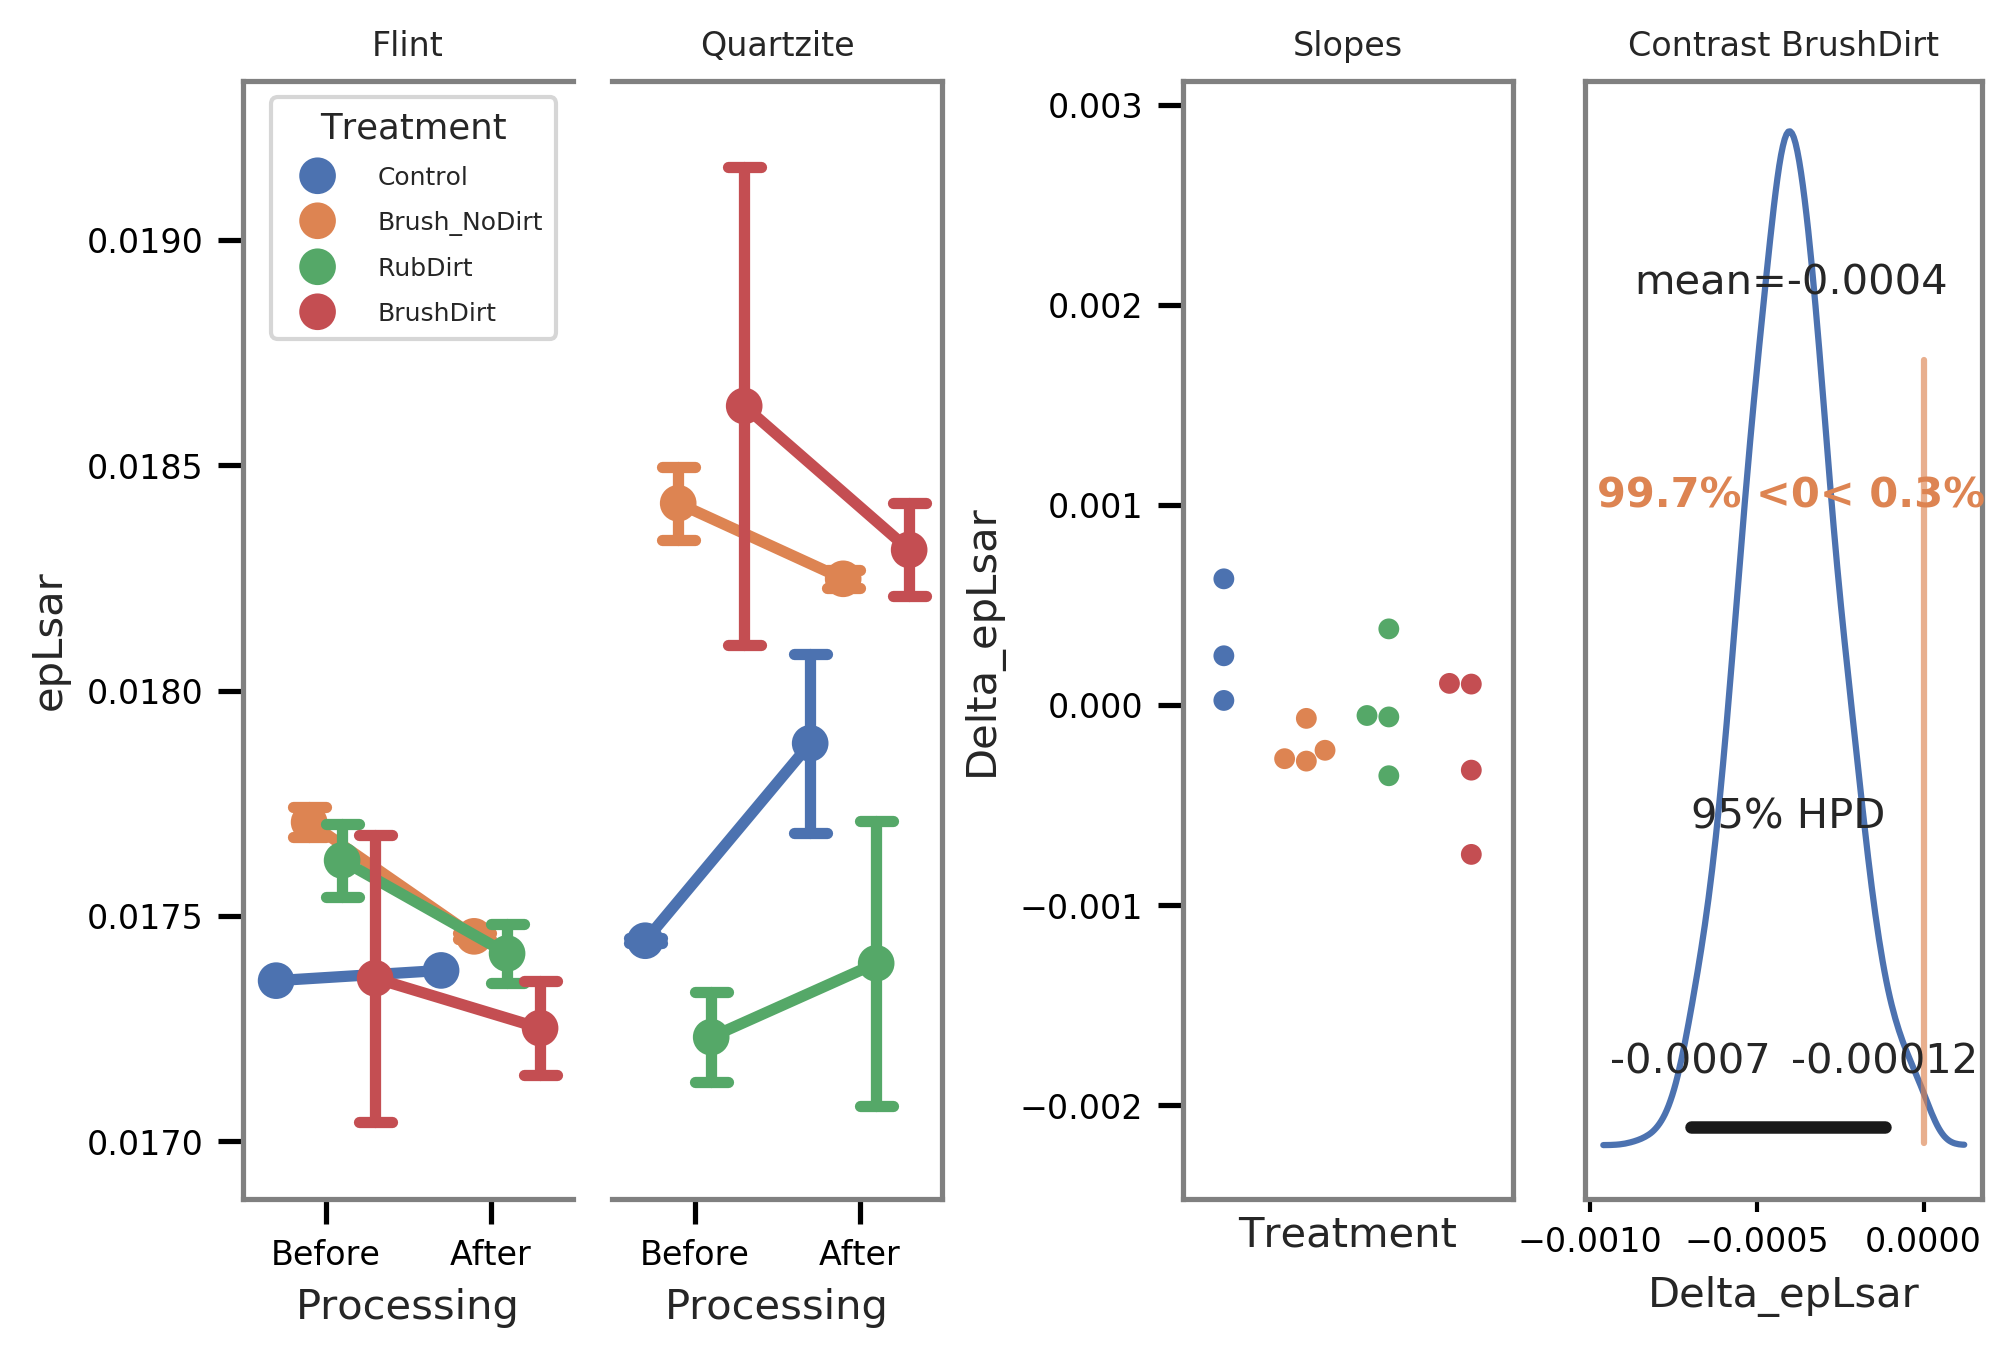

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


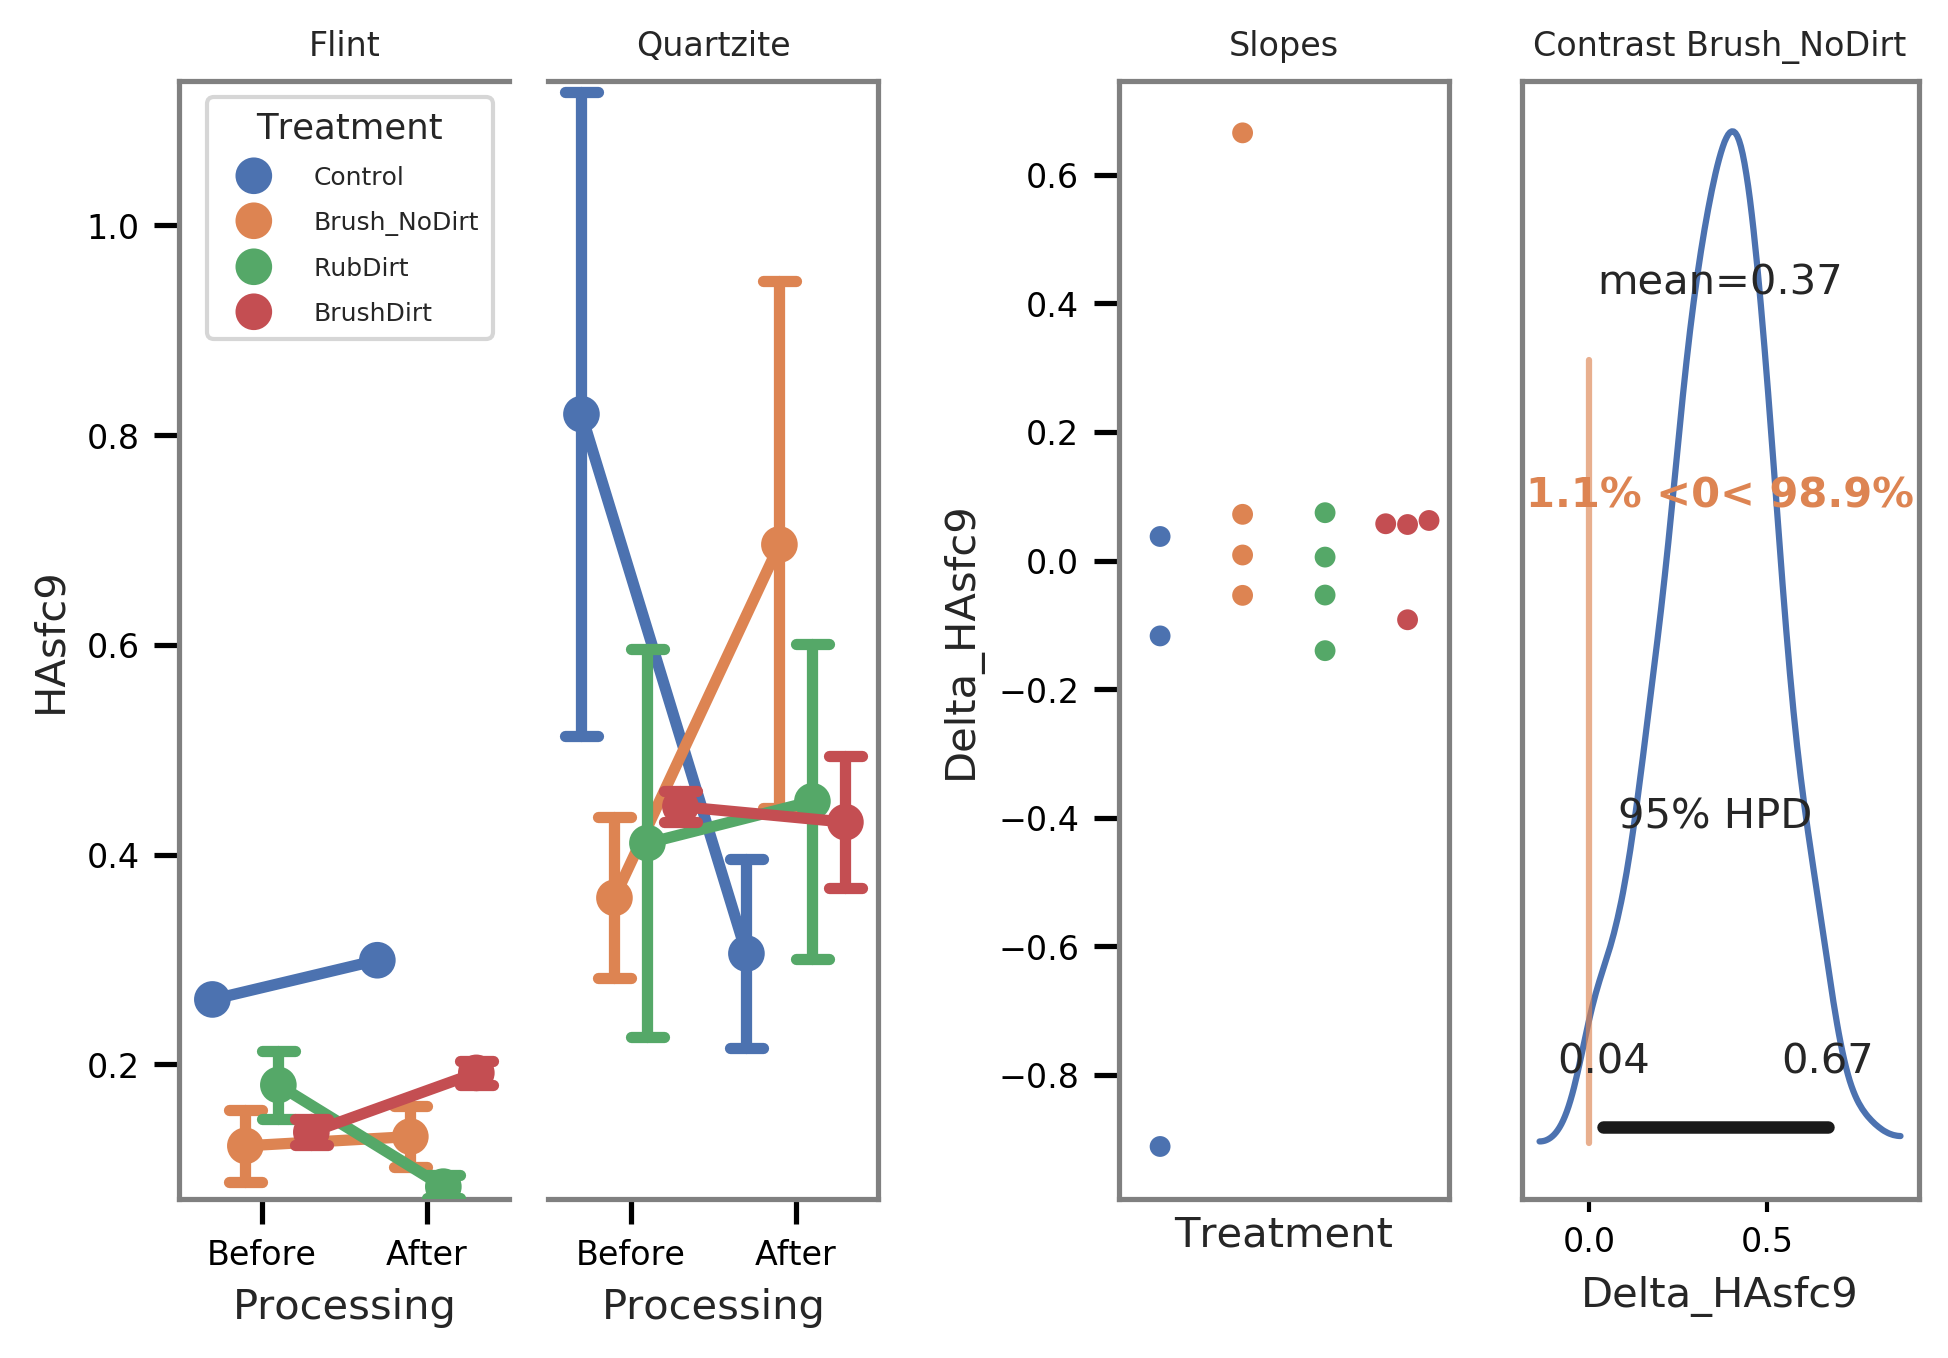

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


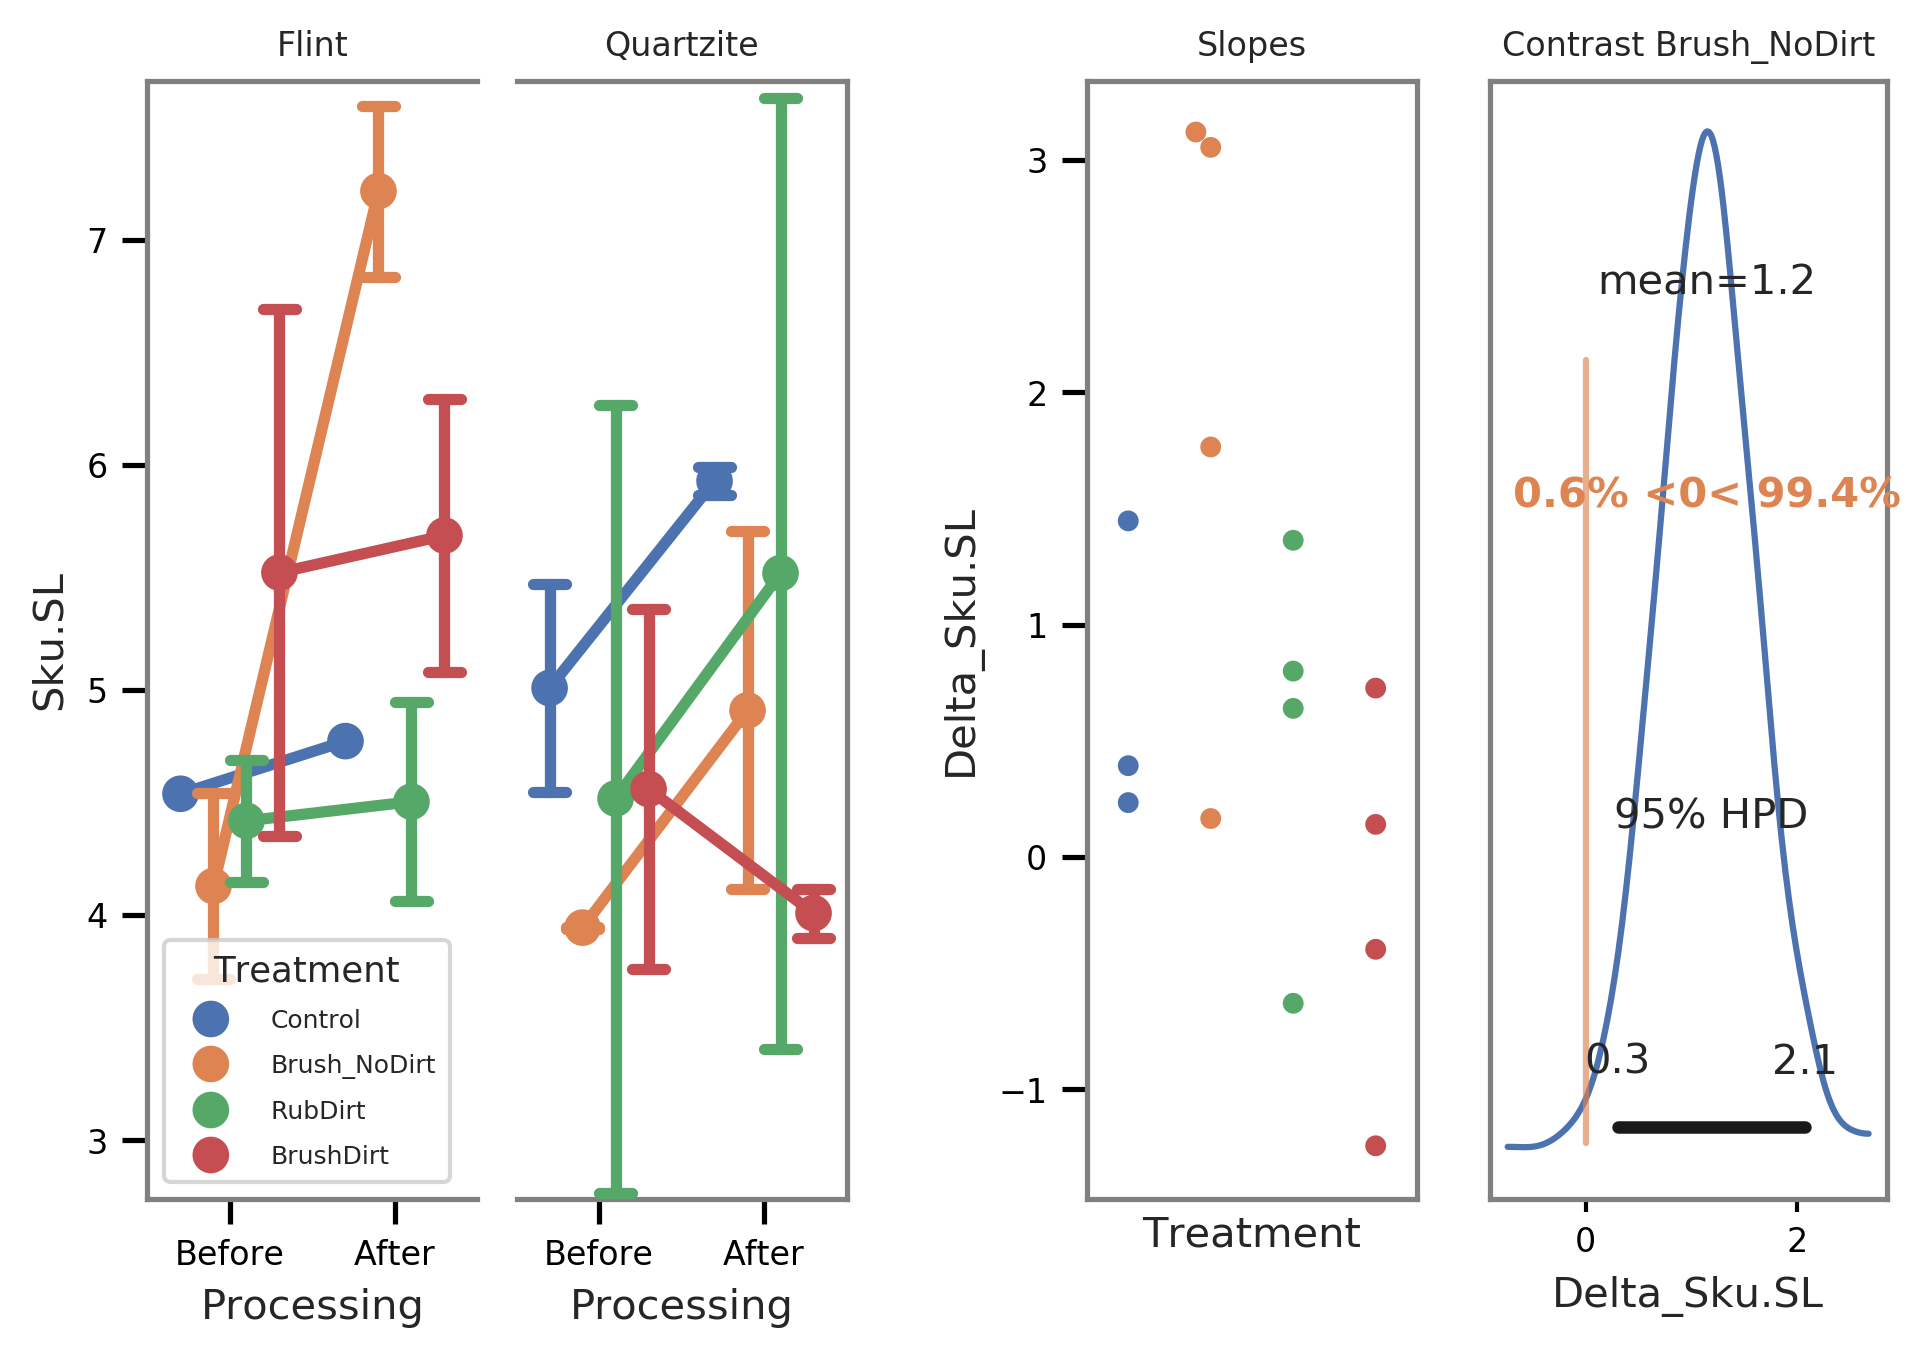

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


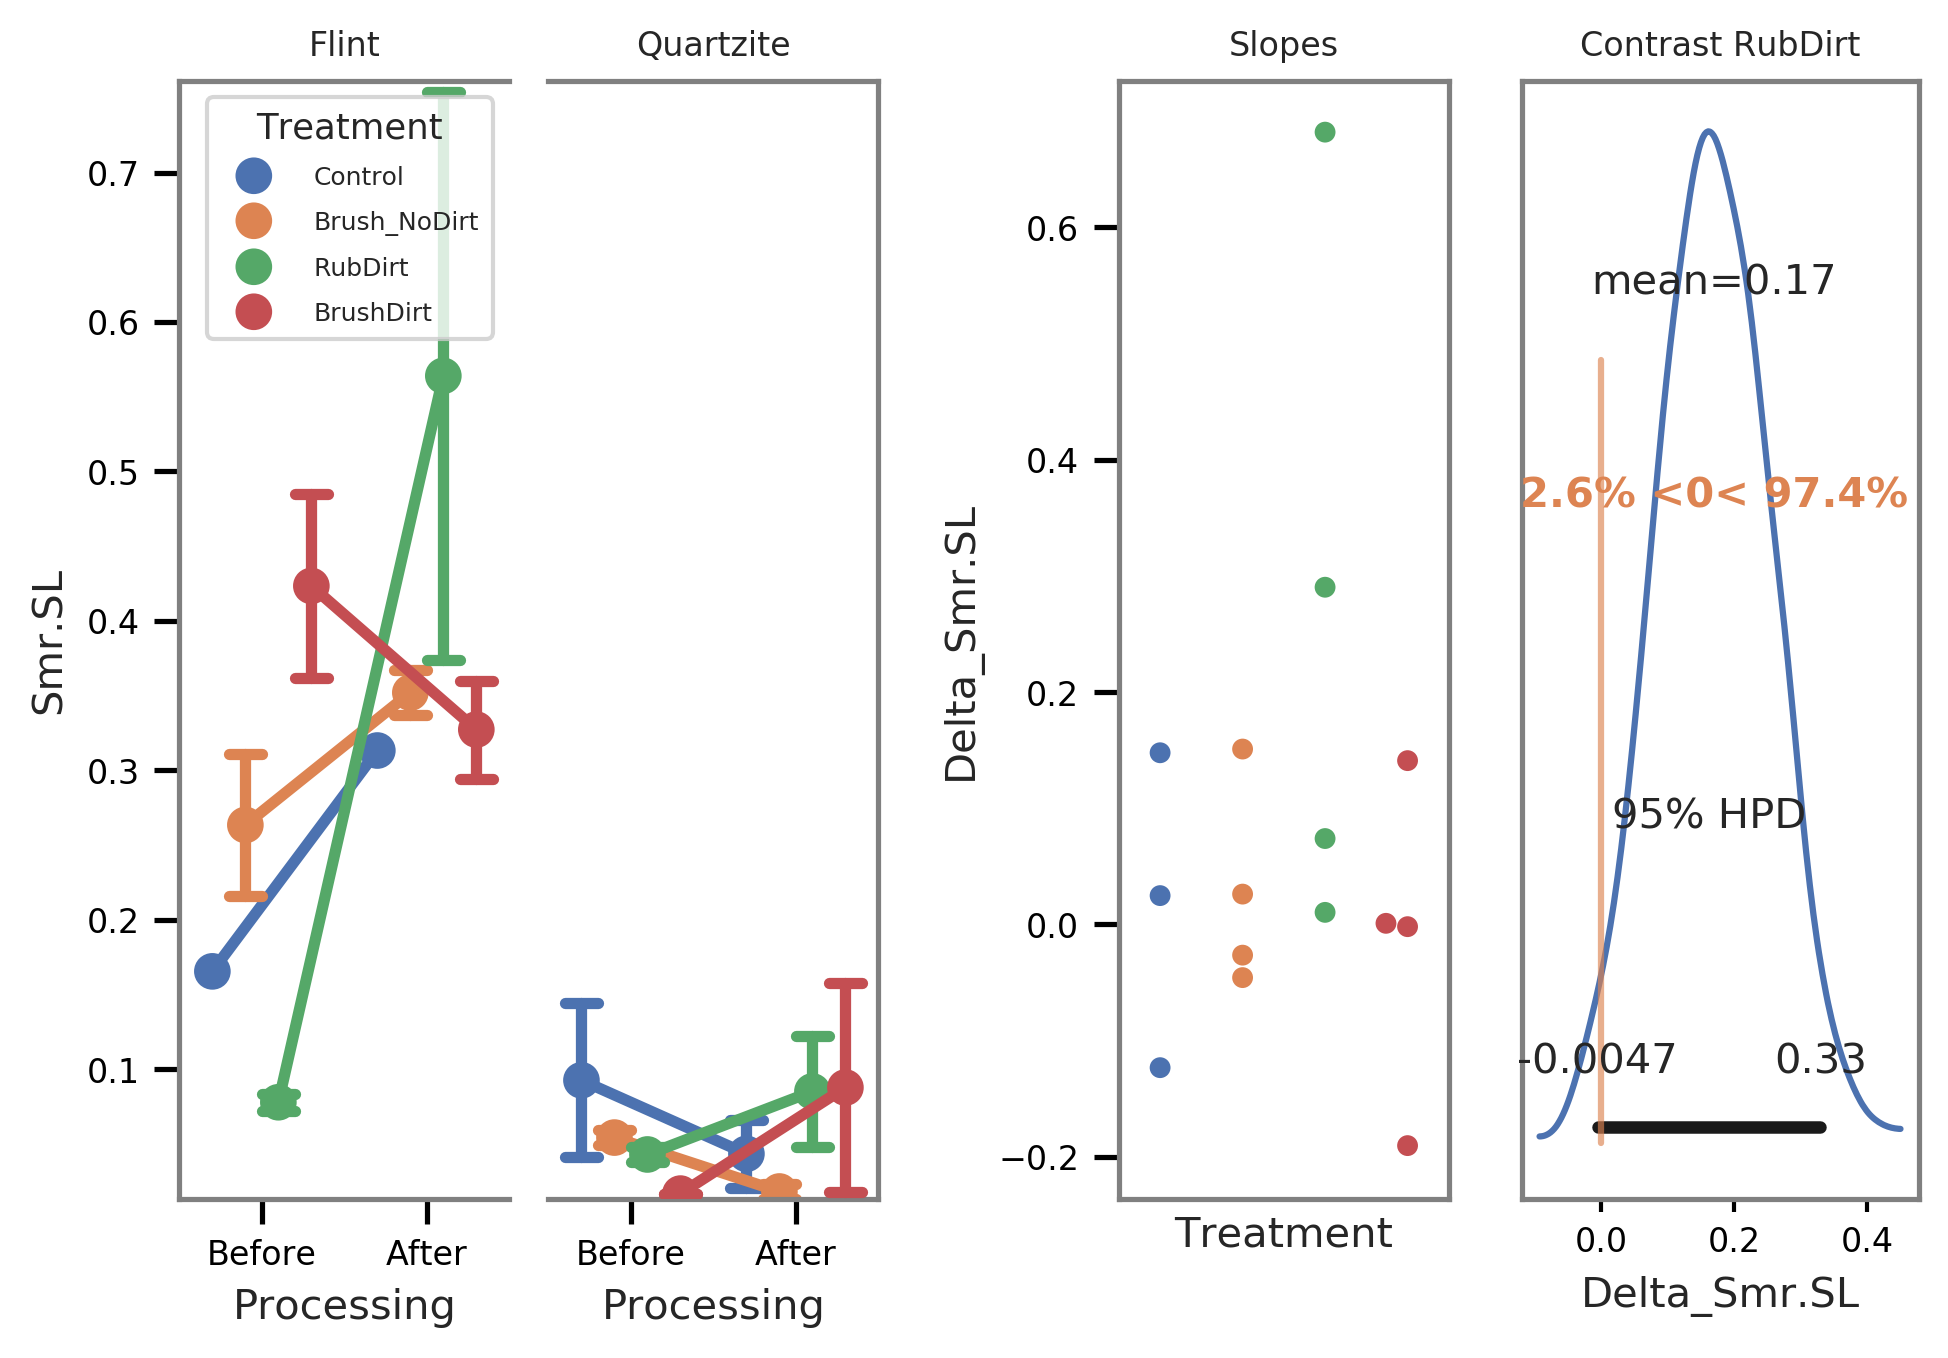

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


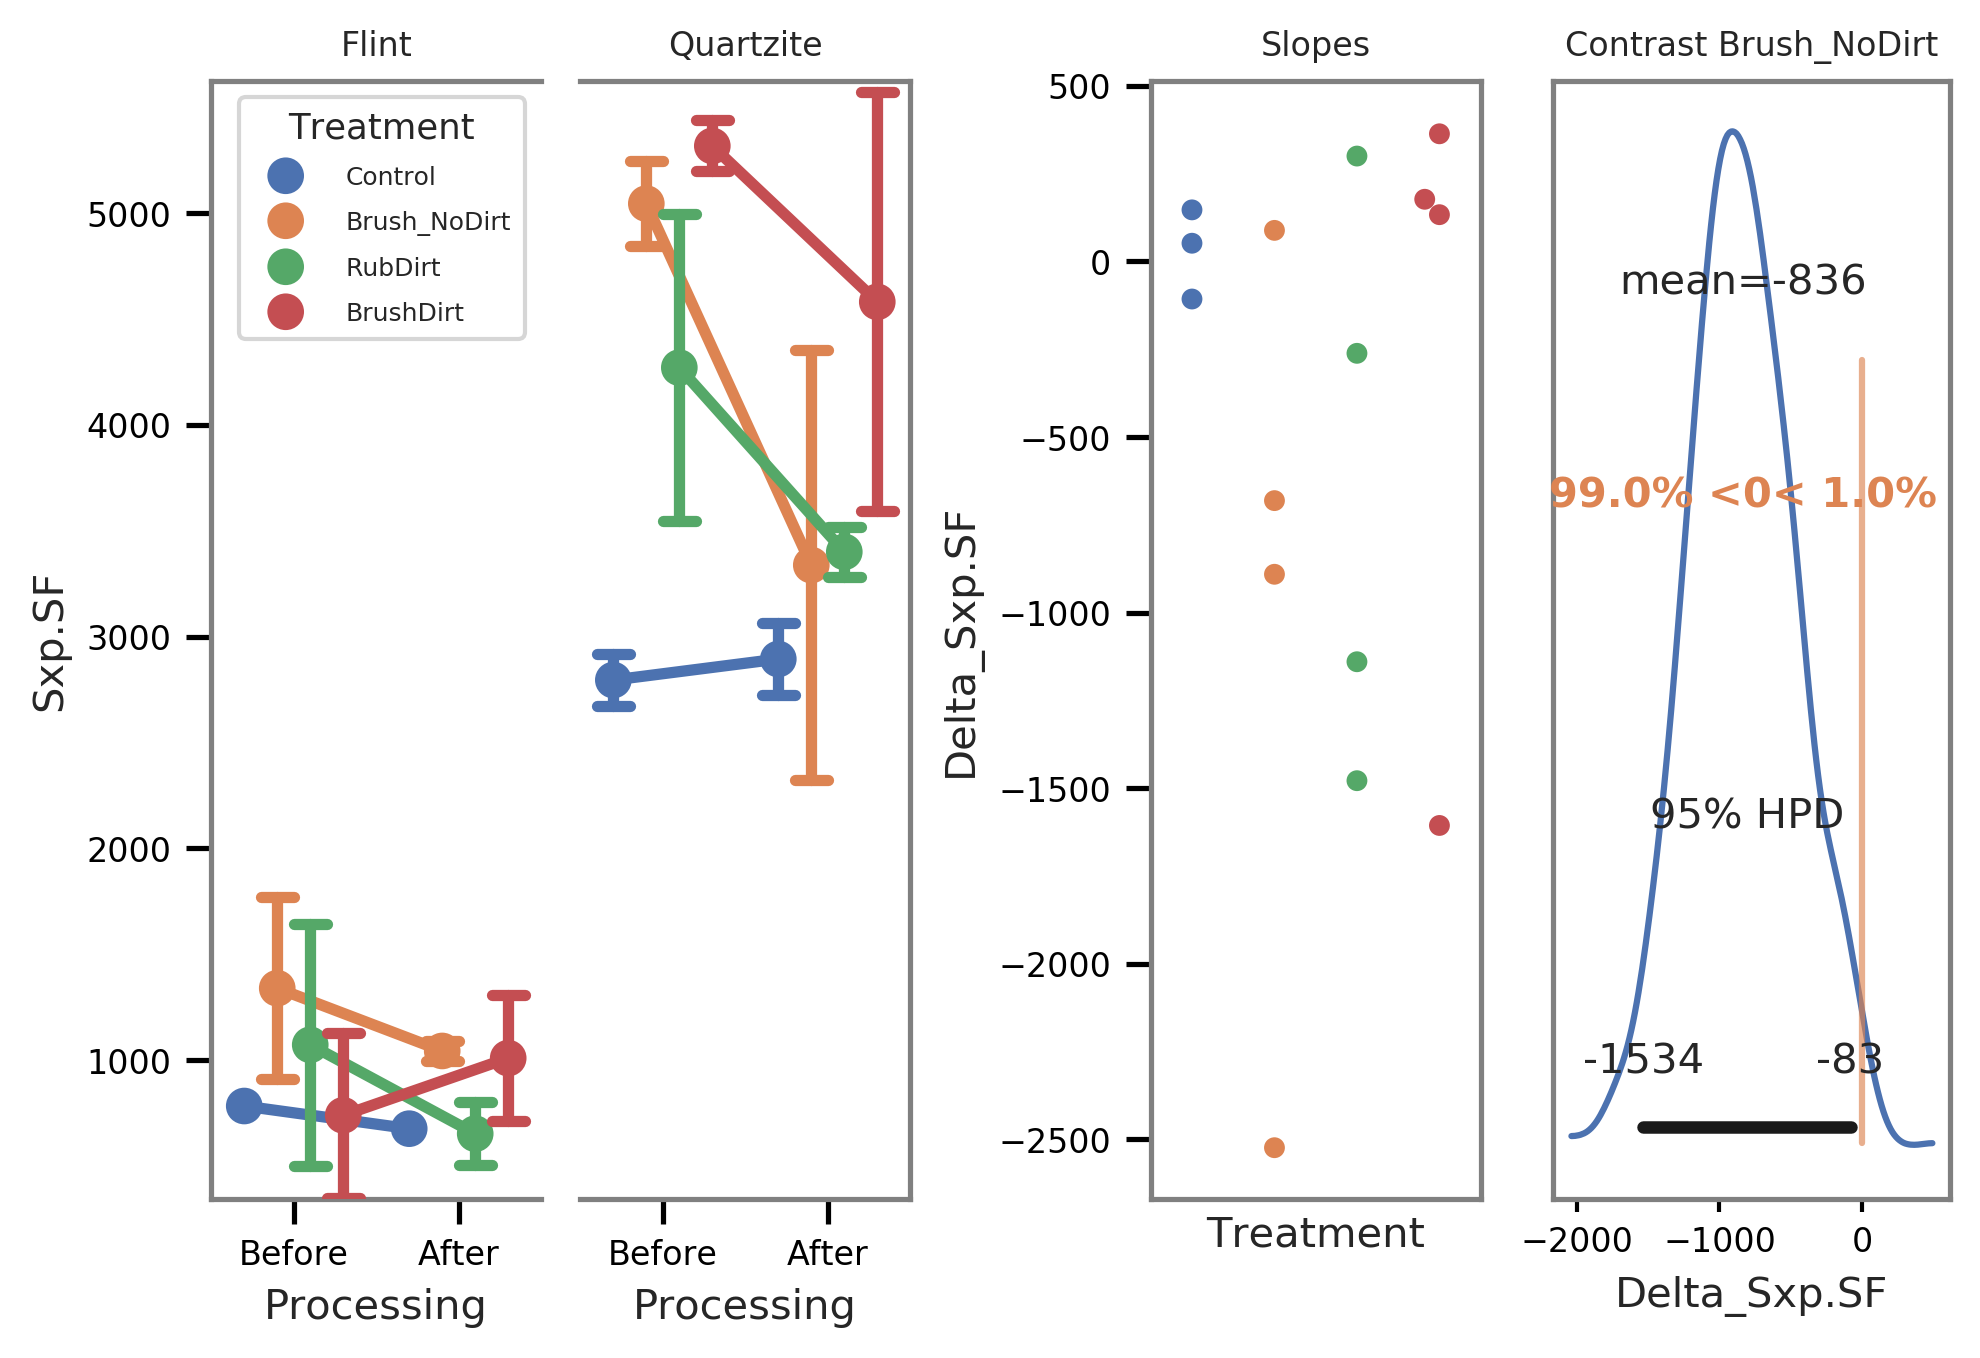

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


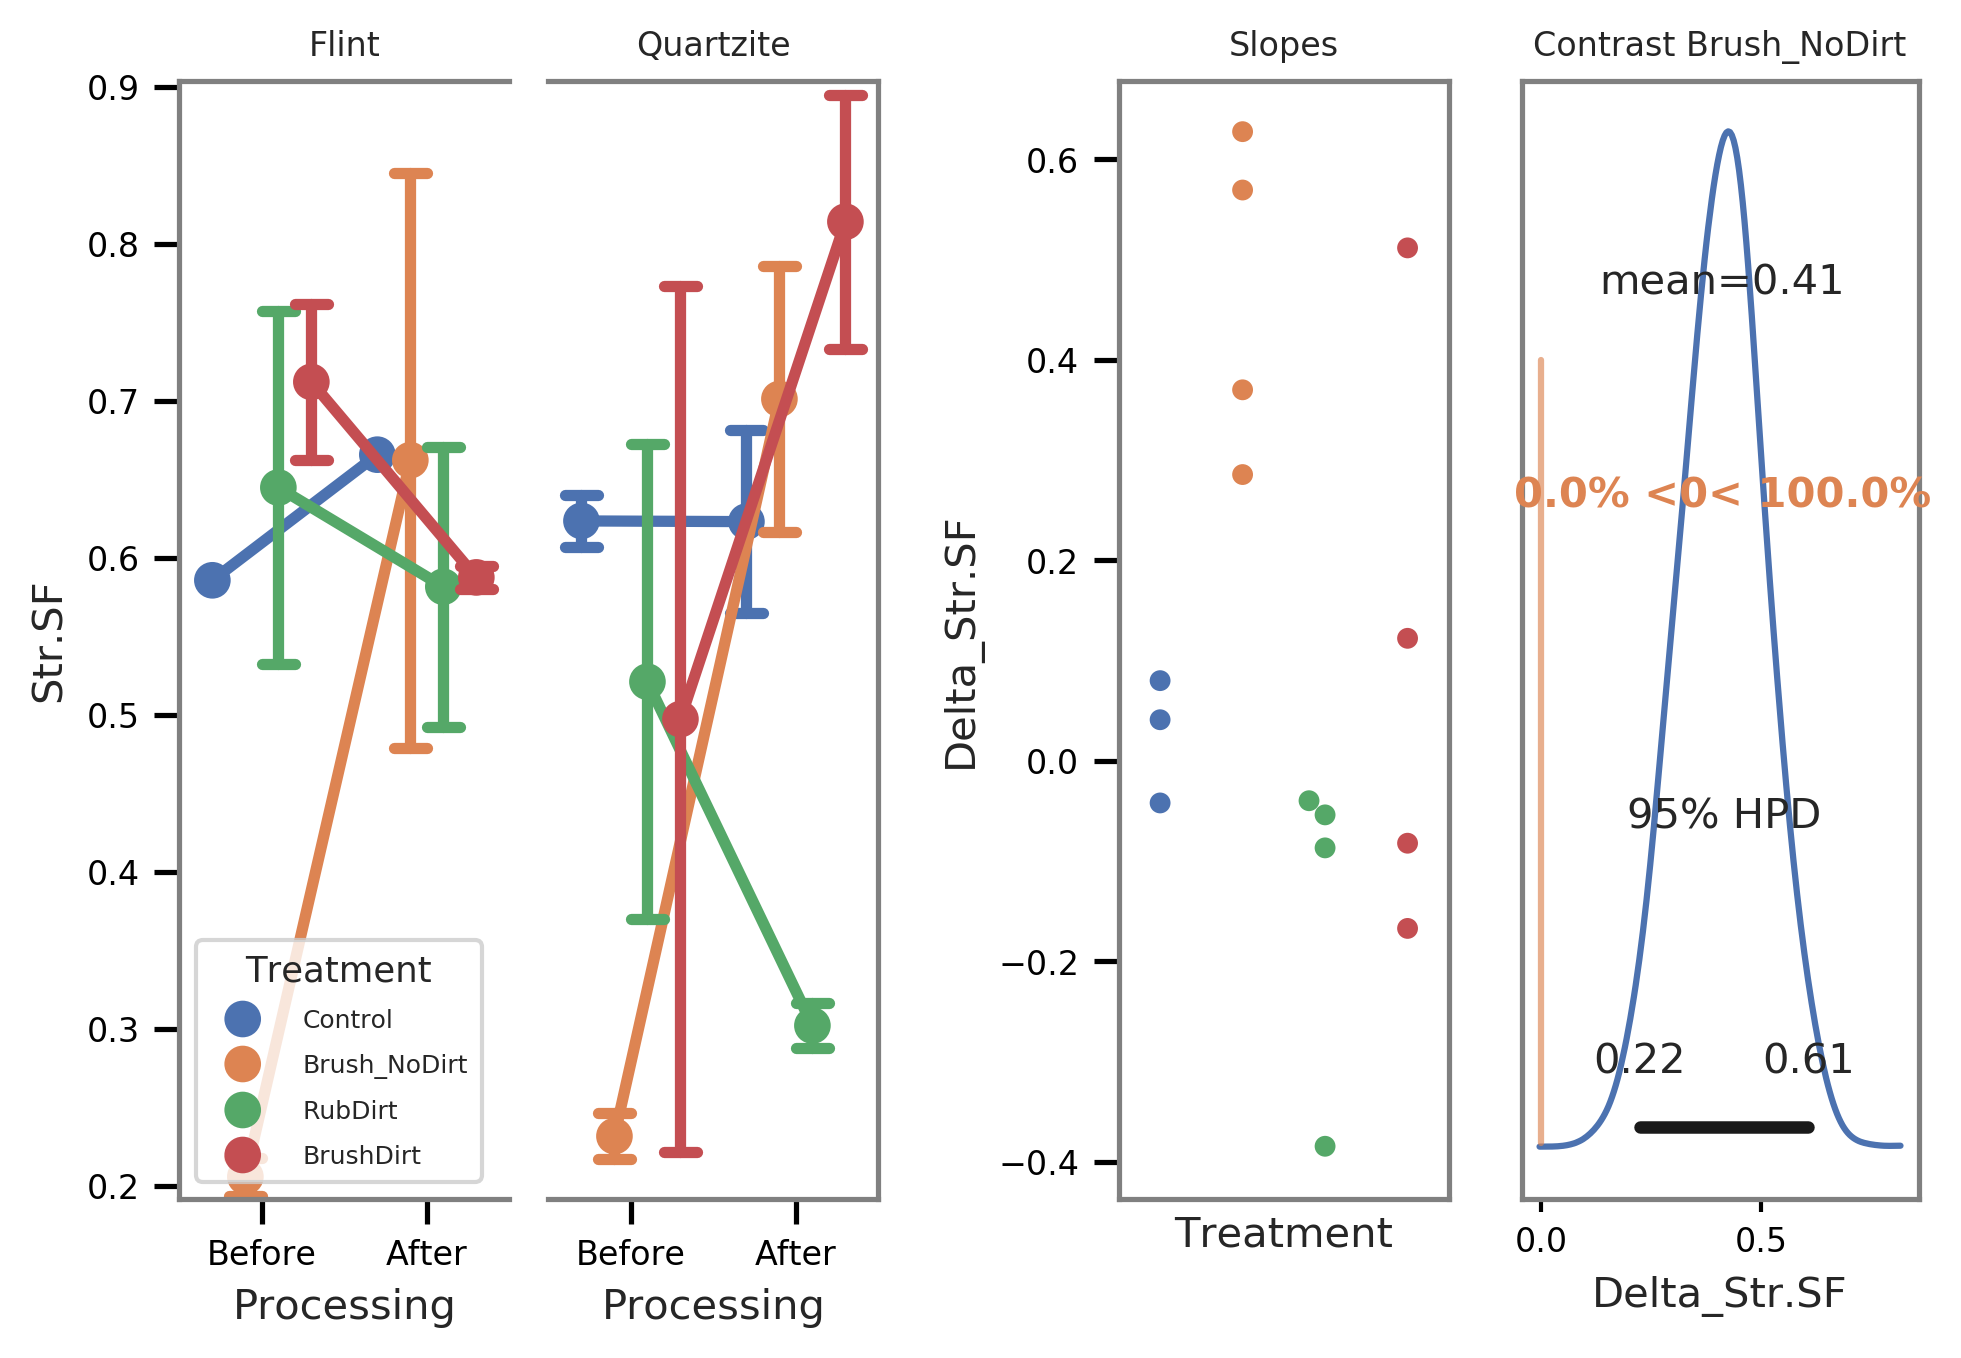

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


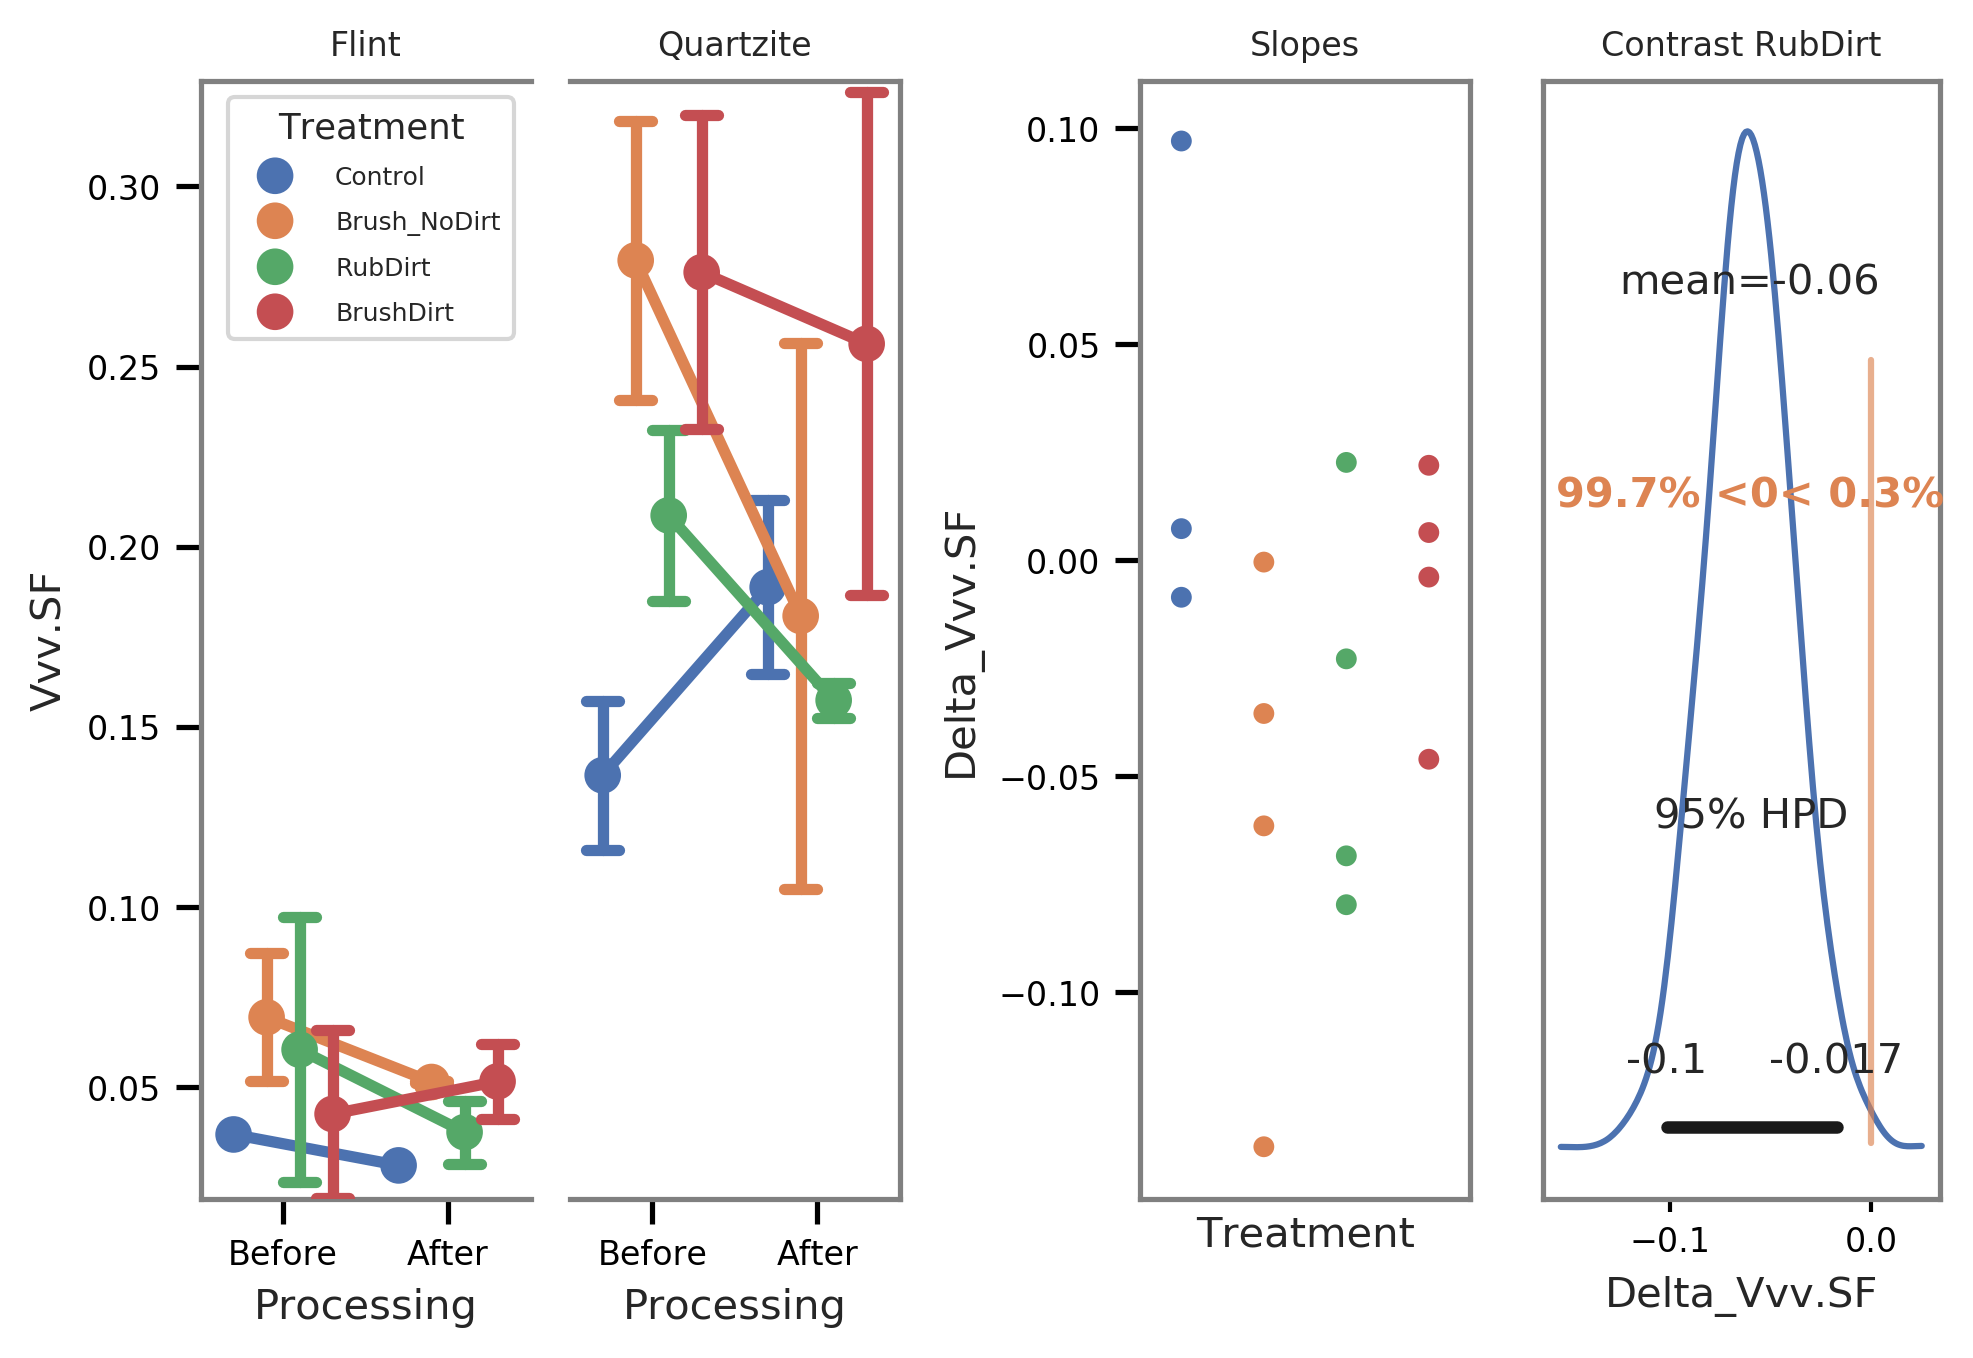

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


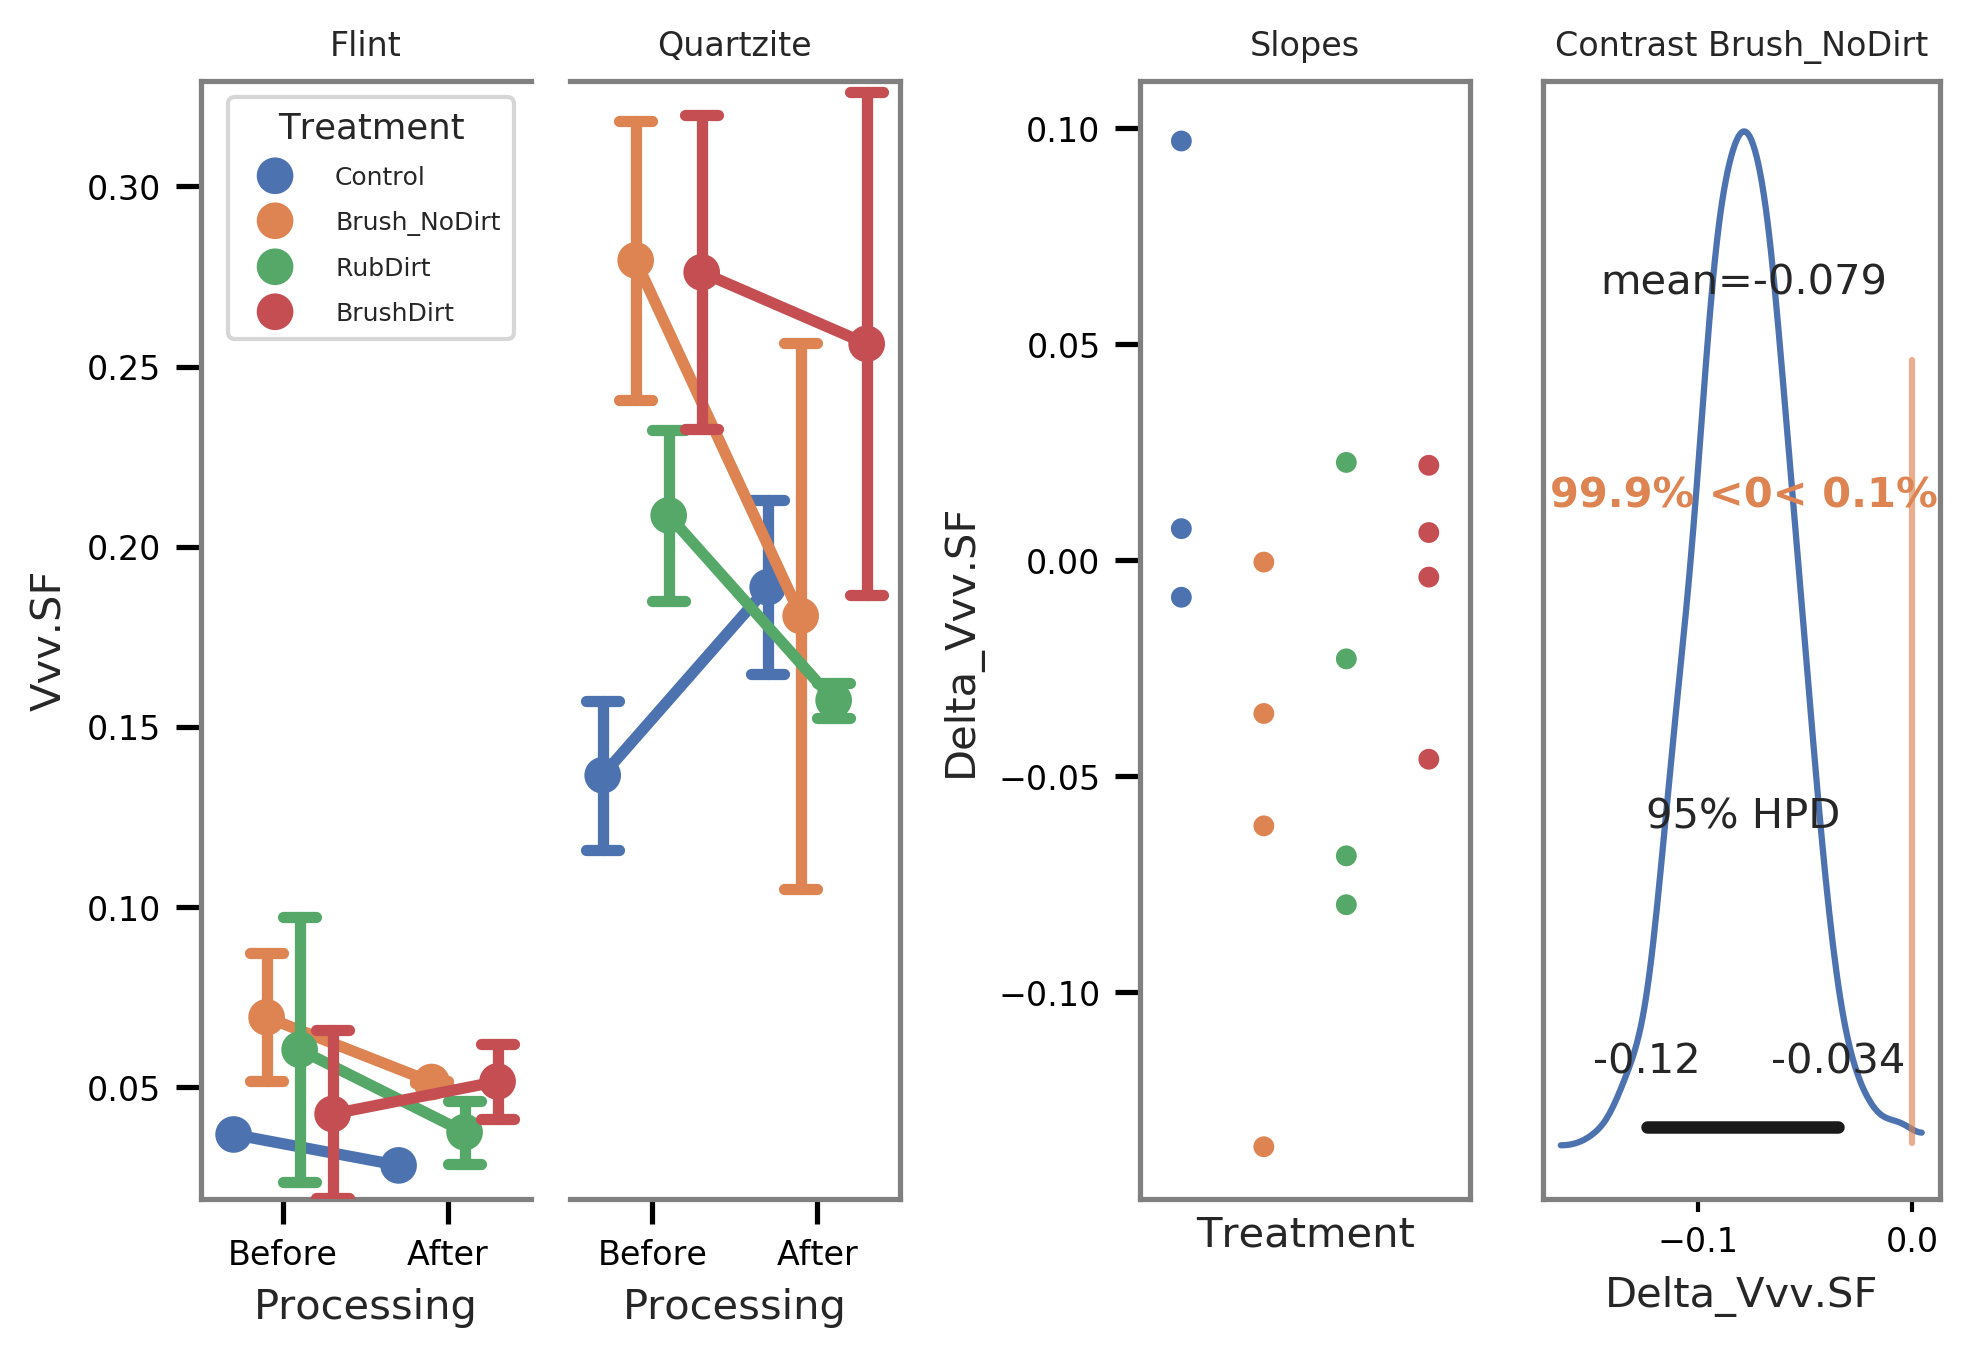

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


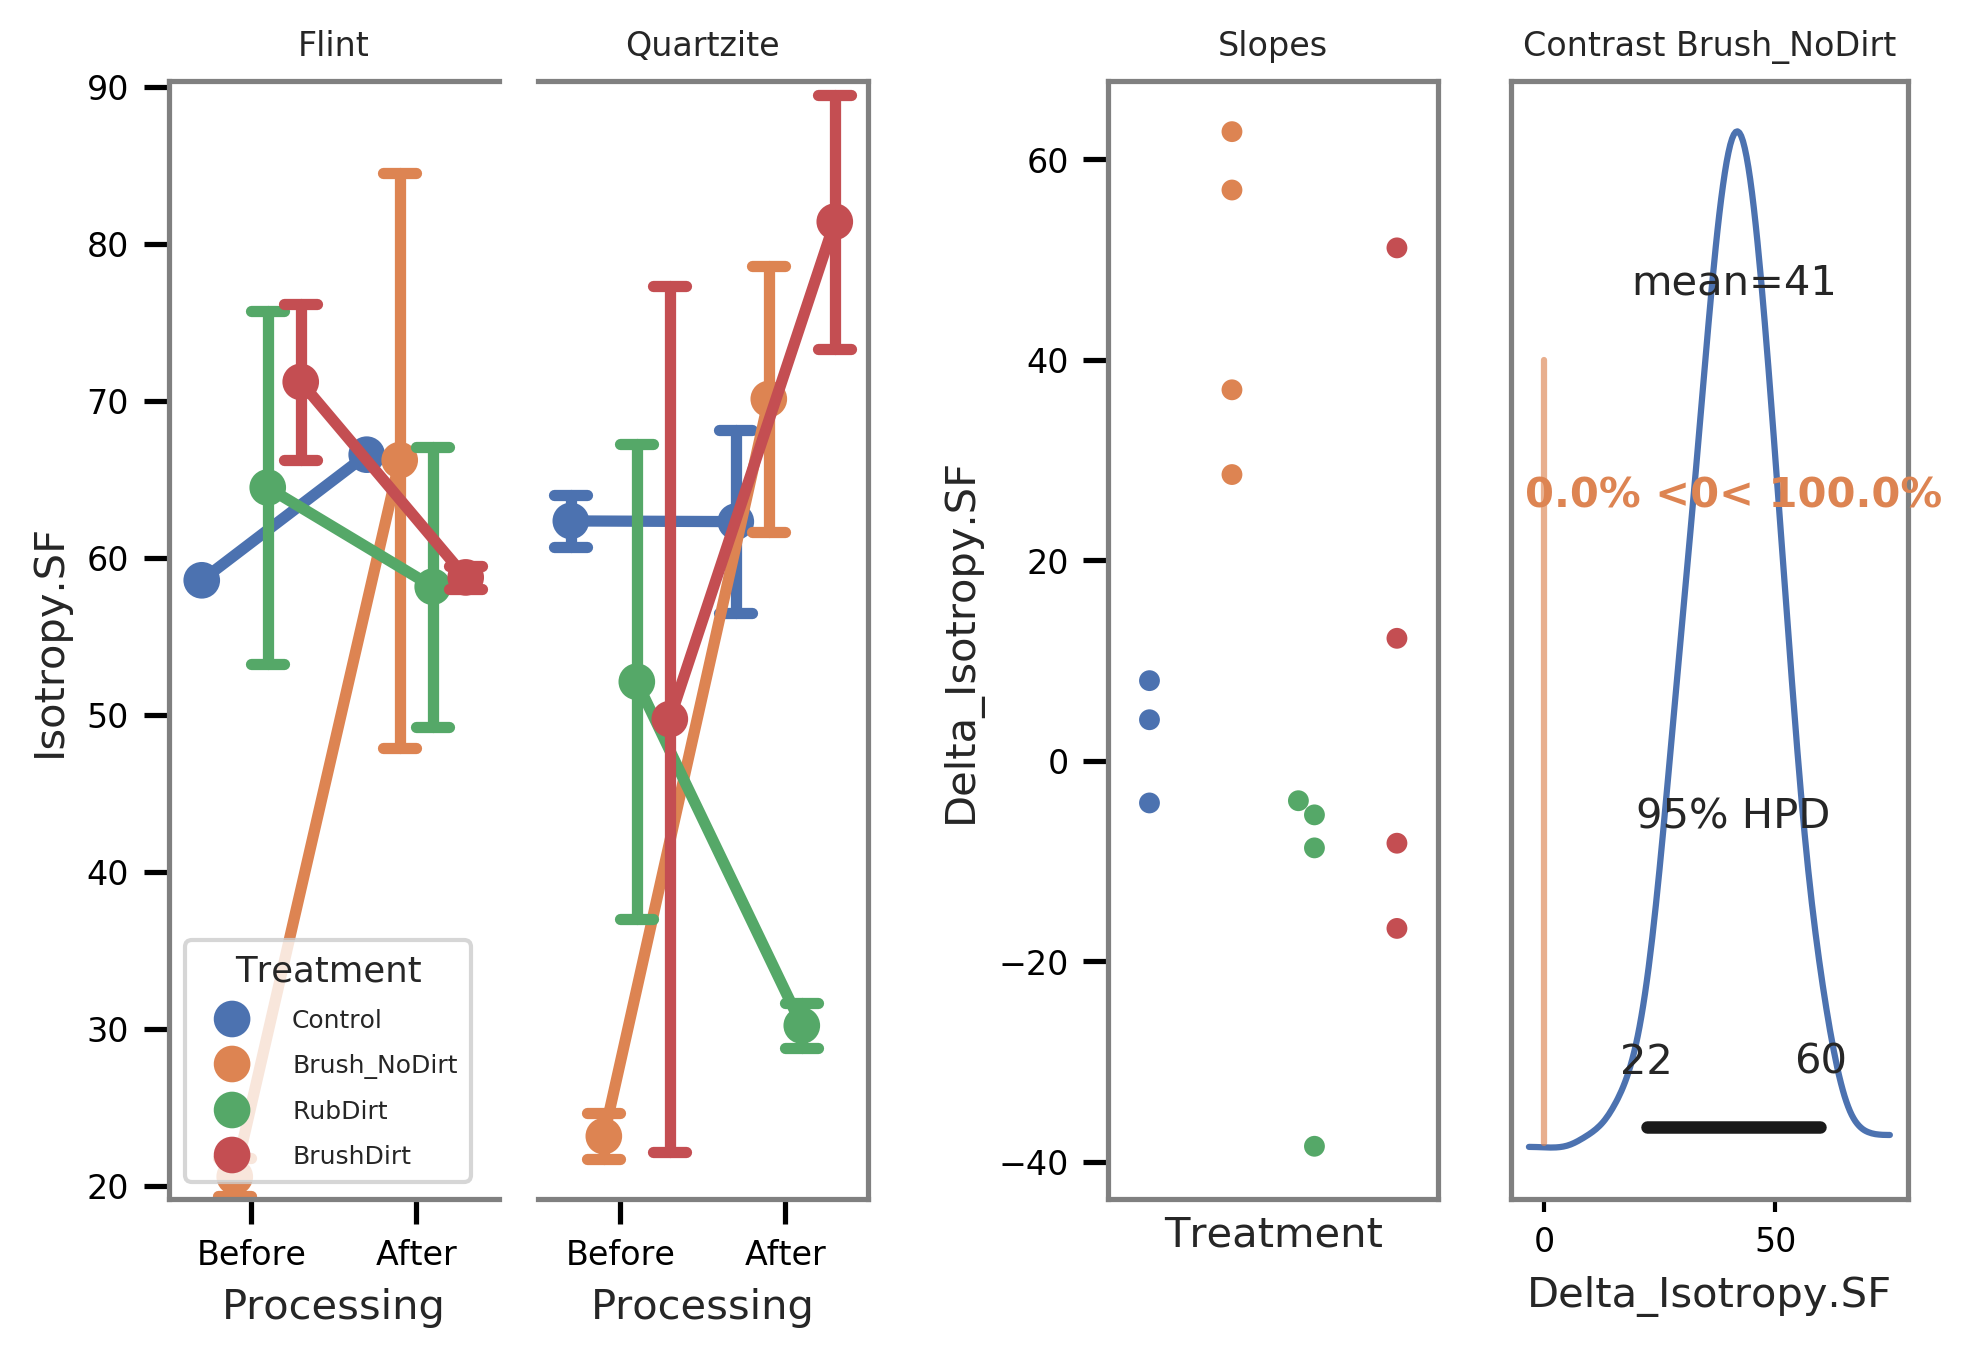

/home/bob/.local/lib/python3.7/site-packages/ipykernel_launcher.py:156: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


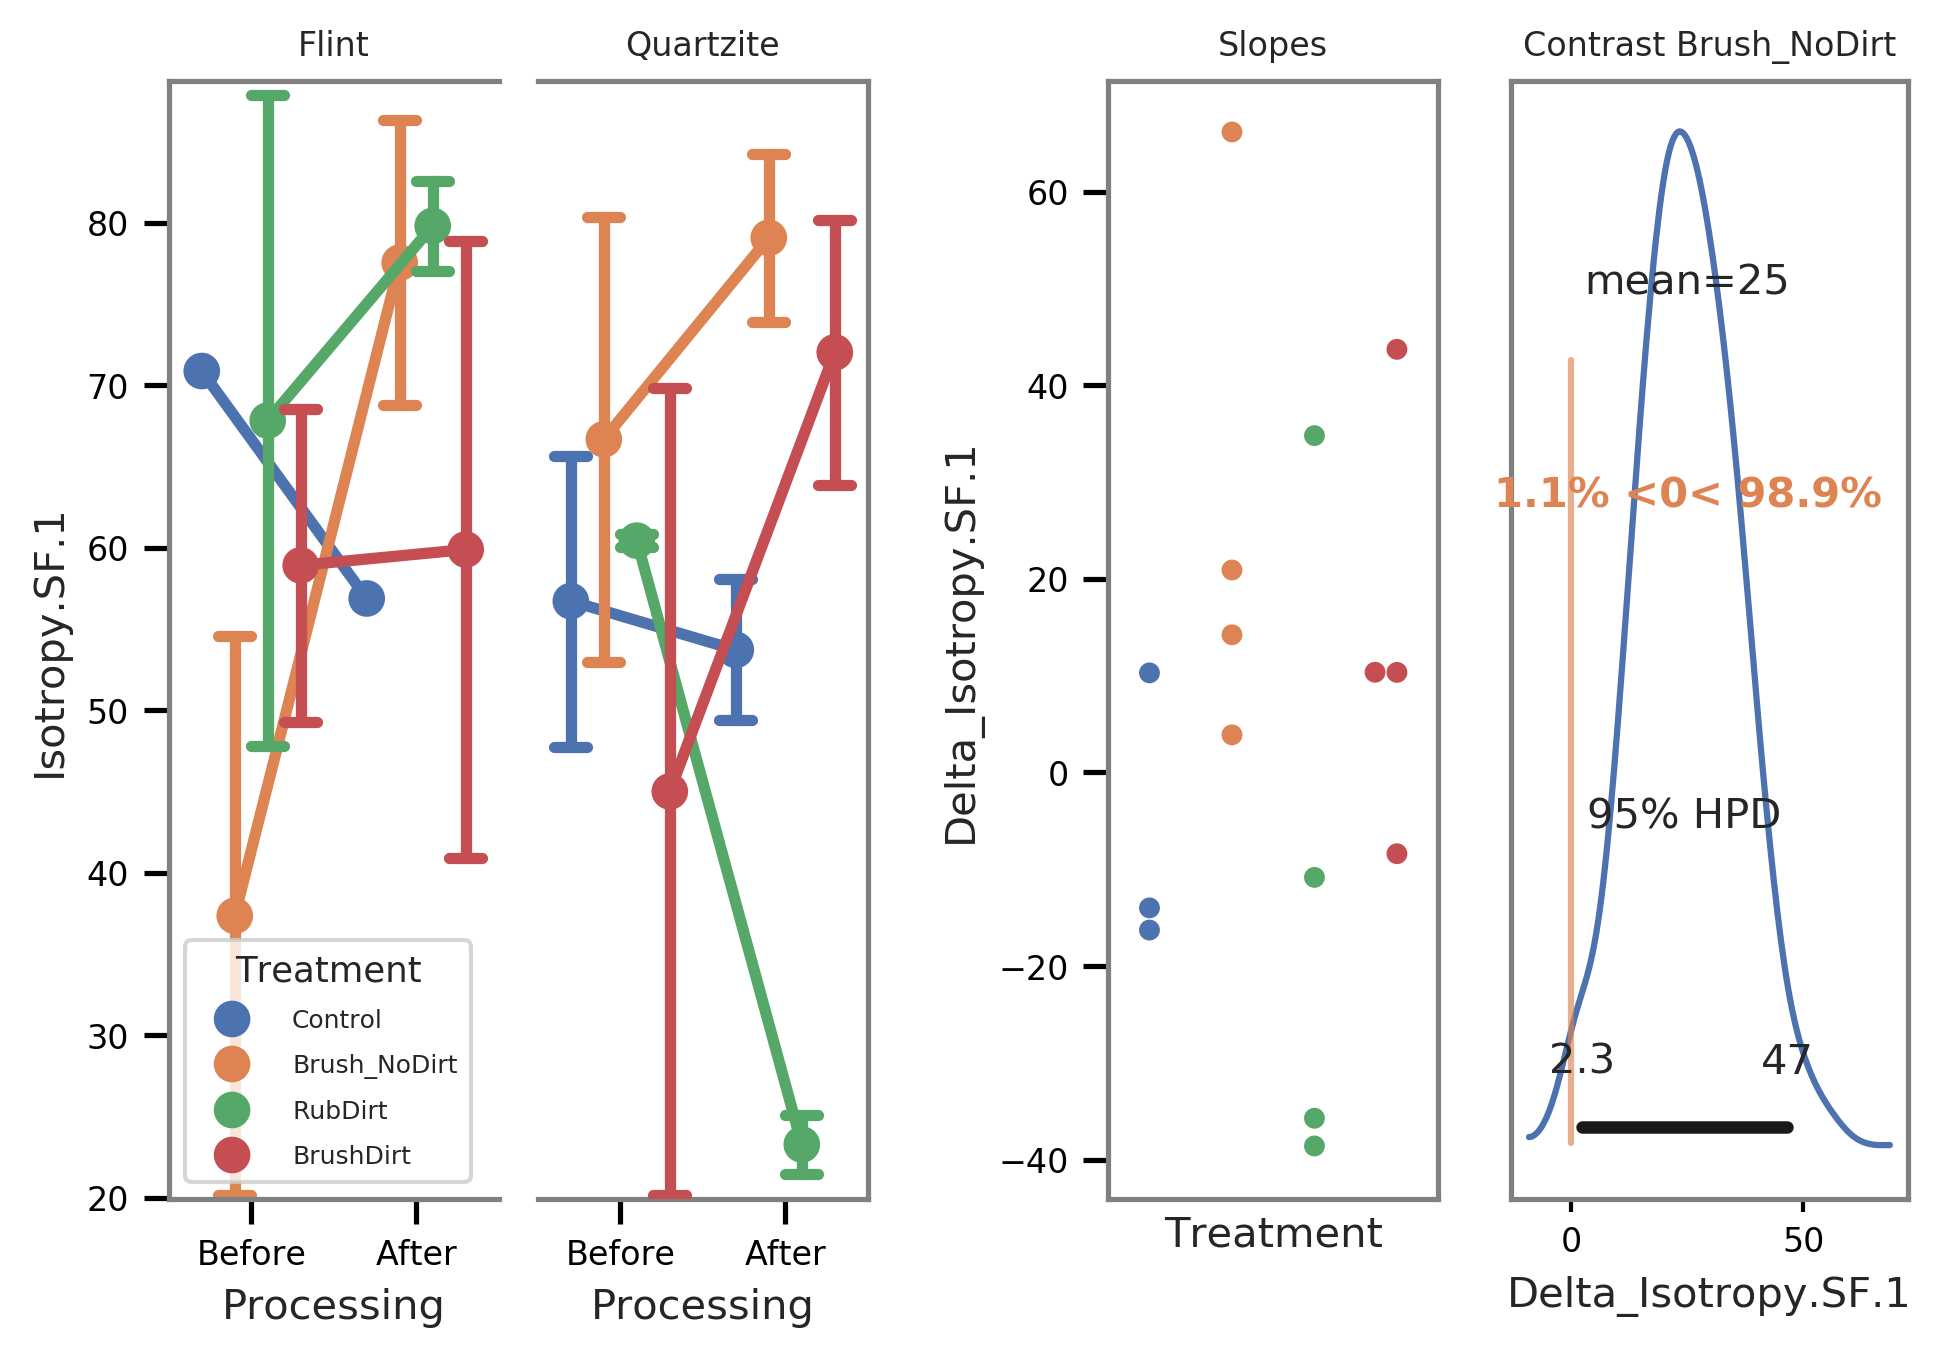

In [18]:
for index, row in dfSig[dfSig.anySig].iterrows():
    idMeasure = row['measuredQuantity']
    
    # renaming 
    dictTreatment = {'No_No':'Control','Is_No':'Brush_NoDirt','No_Is':'RubDirt','Is_Is':'BrushDirt'}  
    
    # get sample data 
    raw = df[factorNames +  [idMeasure]].replace({'Yes': 'Is'})
    raw['Brush_Dirt'] = raw.Brush +"_" + raw.Dirt    
    raw.rename(columns={"Before.after": "Processing"},inplace=True)
    raw=raw.assign(Treatment=raw.Brush_Dirt)
    raw=raw.replace({"Treatment": dictTreatment})
    
    filtered = pd.get_dummies(df[factorNames +  [idMeasure]], columns=['Before.after'])
    filtered['Weighted_'+idMeasure] = filtered[idMeasure]*filtered['Before.after_After']-filtered[idMeasure]*filtered['Before.after_Before']
    filtered = filtered.groupby(['Material','Brush','Dirt','Area']).sum().reset_index()[['Material','Brush','Dirt','Area','Weighted_'+idMeasure]]
    filtered = filtered.replace({'Yes': 'Is'})
    filtered = filtered.rename(columns={'Weighted_'+idMeasure : 'Delta_' +idMeasure})    
    boxDF = filtered
    boxDF['Brush_Dirt'] = boxDF.Brush +"_" + boxDF.Dirt    
      
    boxDF=boxDF.assign(Treatment=boxDF.Brush_Dirt)
    boxDF=boxDF.replace({"Treatment": dictTreatment})
    
    melt = pd.DataFrame()
    melt["Factor1"] = filtered['Brush']+"_Brush_" + filtered['Dirt'] + "_Dirt"
    melt["Factor2"] = filtered["Material"]
    melt['Value'] = filtered['Delta_'+idMeasure]
    mu_Val = melt['Value'].mean()
    sig_Val = melt['Value'].std(ddof=1)
    
    with open(inpath + 'model_{}.pkl'.format(idMeasure), 'rb') as buff:
        data = pickle.load(buff) 
        
    basic_model, trace = data['model'], data['trace']
    b1_sample = sig_Val*trace['b1']+mu_Val
    
    # dict for column filtering 
    column_dict = {'No_Brush_Is_Dirt_vs_No_Brush_No_Dirt':'No_Is',
                  'Is_Brush_No_Dirt_vs_No_Brush_No_Dirt': 'Is_No',
                  'Is_Brush_Is_Dirt_vs_No_Brush_No_Dirt': 'Is_Is'
                  } 
           
    for indexContrast, (key, value) in enumerate(x1contrast_dict.items()):
            contrast = np.dot(b1_sample, value)

            hpd = arviz.hpd(contrast)                    
            significance = 0.0 <= hpd[0] or 0.0 >= hpd[-1]  
            
            if significance:
                # short version label
                colKey = column_dict[key] 
                
                # short version renamed
                colKeyRenamed = dictTreatment[colKey] 
                                
                # compute figsize
                widthMM = 190 
                widthInch = widthMM / 25.4
                ratio = 0.66
                heigthIch = ratio*widthInch
                
                # create figure 
                fig = plt.figure(figsize=(widthInch,heigthIch), dpi= 300, facecolor='w');
                axisWidths = np.array([10,1,10,7,10,2,12])
                numCols = sum(axisWidths)
                axisWidths,numCols,np.cumsum(axisWidths)

                ax =  [None] * len(axisWidths)
                for index,width in enumerate(axisWidths):

                    # get start point 
                    start = 0 if index == 0 else np.cumsum(axisWidths)[index-1]

                    ax[index] = plt.subplot2grid((1,numCols), (0, start), colspan=width)
                
                                
                # compute common y axis for point plots 
                ylims = (0.99*raw[idMeasure].min(),raw[idMeasure].max()*1.01)
                    
                dodgeVal = 0.6
                
                # ============ Point plot ===============
                    
                mat1 = "Flint"
                ax[0].set_ylim(ylims)
                g = sns.pointplot(data = raw[raw.Material==mat1], x="Processing", y=idMeasure,
                            hue="Treatment",
                            capsize=.2,  dodge=dodgeVal,
                            hue_order=['Control','Brush_NoDirt','RubDirt','BrushDirt'],
                                  order=['Before','After'],
                           ax=ax[0])
                ax[0].set_title('{}'.format(mat1))
                ax[0].spines['right'].set_visible(False)
                legend = g.legend_
                for text in legend.get_texts():
                    text.set_fontsize(6)
                #g.legend_.remove()
                
                # =========== Placeholder ==============
                plotEmpty(ax[1])

                
                # ============ Point plot ===============
                currentAxis = ax[2]
                mat2 = "Quartzite"
                currentAxis.set_ylim(ylims)
                g = sns.pointplot(data = raw[raw.Material==mat2], x="Processing", y=idMeasure,hue="Treatment",
                            capsize=.2,  dodge=dodgeVal,
                            hue_order=['Control','Brush_NoDirt','RubDirt','BrushDirt'],
                                  order=['Before','After'],
                           ax=currentAxis)
                currentAxis.set_title('{}'.format(mat2))
                currentAxis.set_yticks([])
                currentAxis.set_ylabel('')
                currentAxis.spines['left'].set_visible(False)                
                g.legend_.remove()
                
                # =========== Placeholder ==============
                plotEmpty(ax[3])

                # ============ Slope plot ===============
                currentAxis = ax[4]
                g = sns.swarmplot(x="Treatment", y="Delta_"+idMeasure,
                            #data = boxDF[(boxDF.Brush_Dirt == colKey) | (boxDF.Brush_Dirt == 'No_No')],
                            data = boxDF,
                            #order=['No_No','Is_No','No_Is','Is_Is'],
                            order=['Control','Brush_NoDirt','RubDirt','BrushDirt'],
                            #inner="sticks",                                  
                            ax=currentAxis)
                currentAxis.set_title('Slopes')
                currentAxis.set_xticks([])
                
                
                # =========== Placeholder ==============
                plotEmpty(ax[5])
                
                # ============ Posterior plot ===============  
                currentAxis = ax[6]
                g = pm.plot_posterior(contrast, ref_val=0.0, ax=currentAxis,bins=50,credible_interval=0.95)
                currentAxis.set_xlabel("Delta_{}".format(idMeasure))
                currentAxis.set_title('Contrast {}'.format(colKeyRenamed))
                currentAxis.spines['right'].set_visible(True)
                currentAxis.spines['left'].set_visible(True)
                currentAxis.spines['top'].set_visible(True)
                currentAxis.spines['bottom'].set_visible(True)
                
                # set color of frames            
                for ax in ax:
                    ax.tick_params(color='black', labelcolor='black')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('gray')
                
                
                # finalize figure 
                fig.tight_layout()              
                plt.savefig(outpath+'/Showcase_{}_{}.pdf'.format(idMeasure,key), bbox_inches='tight')
                plt.show()
                